Faltam:


1.   Corrigir o ultimo plot quando encontra o PANC 
2.   Simplificar a formacao dos azuis sem escolha de vermelho
3.   Verificar os problemas que ocorrem na formacao do Cenario 16h
4.   Aparar as funcoes de formBottom sem uso
5.   Implementar separadamente o Reinforcement Learning
6.   Testar a depuracao com reward para as actions



In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [ ]:
# dimensoes do ambiente
envirX = 40 # eixo X do ambiente monitorado
envirY = 35  # eixo Y do ambiente monitorado

deck = list(range(1,12)) # lista de numeros a serem sorteados para identificar clusters

# classe Node
class Node():
    def __init__(self):
        models = ["SkyMote","MicazMote","TelosB"]
        drates = [0.05,0.2]
        self.nodeID = np.random.randint(0,101)
        self.model = np.random.choice(models)
        self.assoc = False
        self.posX = np.random.randint(0,envirX)
        self.posY = np.random.randint(0,envirY)
        self.datarate = np.random.choice(drates)
        self.radius = 10
        self.hopToPAN = -1
        # self.idCluster = random.randint(1,10)
        self.idCluster = 0
        self.energy = random.randrange(50,200)
        self.isCH = False
        self.child = []
        self.childCH = []
        self.hasParent = False
        self.parent = None
        self.hasRedNeighbor = False
        self.neighbors = []
        self.nearReds = []
        self.nearRedsNon = []
        self.nearBlues = []
        self.nearRedsDifCluster = []
        self.reds = 0
        self.blues = 0
        self.potencial = 0
        self.nearBluesPotencial = []
        self.redsOtherCluster = 0

    def countBlue(self): # conta azuis proximos
        lista = self.achBlue()
        count = len(lista)
        return count

    def countRed(self): # conta vermelhos proximos
        lista = self.achRed()
        count = len(lista)
        return count

    def as_dict(self): # retorna tabela para tomada de decisao
        mylist = self.neighbors
        mylist = list(dict.fromkeys(mylist)) #'Neighborhood': [m.nodeID for m in mylist]
        return {'ID': self.nodeID, 'Depth': self.hopToPAN, 'Assoc':self.assoc, #'Datarate': self.datarate, #'Neighborhood': [m.nodeID for m in mylist], 
                'Childs':len(self.child)+len(self.childCH), 'ChildCH':len(self.childCH), 'nearBlue': self.countBlue(), 'nearRed': self.countRed(), 'Energy': self.energy, 'idCluster': self.idCluster}

    def checkAdjNodes(self):
        rangeRF = np.pi*(self.radius)**2
        return rangeRF

    def forcePosition(self, x, y): # forca a posicao do nodo
        self.posX = x
        self.posY = y
    
    def forceDataRate(self,drate): # forca o datarate
        self.datarate = drate
    
    def forceIdCluster(self,node):
        self.idCluster = node.idCluster

    def associateNodes(self, nodes_list, datarate): # busca nodos com base na taxa de aquisicao de dados
        d=0
        if datarate == 'r':
            d=0.2
        elif datarate == 'b':
            d=0.05

        for n in self.neighbors:
            if n.datarate == d and n.assoc == False and n.nodeID != self.nodeID and n.isCH == False:
                self.assoc = True
                n.assoc = True
                n.parent = self
                n.hasParent = True
                self.isCH = True
                self.child.append(n)
        return self.child            

    def associate(self,n): # busca nodos com base na taxa de aquisicao de dados
        for n in self.neighbors:
            if n.datarate == self.datarate and n.assoc == False and n.nodeID != self.nodeID and n.isCH == False:
                n.assoc = True
                n.idCluster = self.idCluster
                n.parent = self
                n.hasParent = True
                self.isCH = True
                self.child.append(n)

    def disassociate(self): # busca nodos com base na taxa de aquisicao de dados
        for n in self.child:
            # if n.datarate == self.datarate and n.assoc == False and n.nodeID != self.nodeID and n.isCH == False:
                n.assoc = False
                self.assoc = False
                n.idCluster = 0
                n.parent = None
                n.hasParent = False
                self.isCH = False
                self.child.remove(n)

    def associateAll(self,n): # busca nodos com base na taxa de aquisicao de dados
        for n in self.neighbors:
            if n.datarate == self.datarate and n.assoc == False and n.nodeID != self.nodeID and n.isCH == False:
                if self.idCluster == 0:
                  random.shuffle(deck)
                  a = len(deck)-1
                  self.idCluster = deck[a]
                  deck.pop()
                self.assoc = True
                n.assoc = True
                n.idCluster = self.idCluster
                n.parent = self
                n.hasParent = True
                self.isCH = True
                self.child.append(n)
    
    def associateAllDifCluster(self,n): # busca nodos com base na taxa de aquisicao de dados
        # for n in self.neighbors:
            if n.nodeID != self.nodeID and n.idCluster != self.idCluster:
                if self.idCluster == 0:
                  random.shuffle(deck)
                  a = len(deck)-1
                  self.idCluster = deck[a]
                  deck.pop()
                self.assoc = True
                n.assoc = True
                n.idCluster = self.idCluster
                n.parent = self
                n.hasParent = True
                self.isCH = True
                self.child.append(n)

    def associatePANC(self,n): # busca nodos com base na taxa de aquisicao de dados
        # for n in self.neighbors:
        #     if n.datarate == self.datarate:
                # if self.idCluster == 0:
                #   random.shuffle(deck)
                #   a = len(deck)-1
                #   self.idCluster = deck[a]
                #   deck.pop()
                self.assoc = True
                n.assoc = True
                n.idCluster = self.idCluster
                n.parent = self
                n.hasParent = True
                self.isCH = True
                self.child.append(n)

    # def listaRedsDifCluster(self):

    def hasRedNeig(self,node):
        for n in self.neighbors:
            if n.datarate == 0.2 and n.idCluster != node.idCluster: # verifica se na lista tem vermelhos de outro ramo
              self.hasRedNeighbor = True

    def farawayCH(self): # retorna no mais longe para ser CH
        lista_dist = []
        for i in range(len(self.child)):
            res = (self.posX - self.child[i].posX)**2 + (self.posY - self.child[i].posY)**2
            dist = np.sqrt(res)
            lista_dist.append(dist)
        if len(lista_dist) > 0:
            m = max(lista_dist)
            p = lista_dist.index(m)
            return self.child[p]
    
    def moreDepth(self): # retorna no mais profundo para ser CH
        lista_dist = []
        for i in range(len(self.child)):
            res = self.child[i].hopToPAN
            lista_dist.append(res)
        if len(lista_dist) > 0:
            m = min(lista_dist)
            p = lista_dist.index(m)
            return self.child[p]

    def selectChildCH(self,n): # seleciona CH filho
        for n in self.child:
           if n.isCH == False and n == self.farawayCH():
                print(f'CH in selectCH = {n.nodeID}')
                n.isCH == True
                self.childCH.append(n)
                self.child.remove(n)
    
    def selectChildCHBU(self,n): # seleciona CH filho
        for n in self.child:
            # if n.isCH == False and n == self.moreDepth():
            if n.isCH == False:
                print(f'CH in selectCHBU = {n.nodeID}')
                n.isCH == True
                self.childCH.append(n)
                self.child.remove(n)

    def defineCH(self,n): # seleciona CH filho
        if n in self.child:
            print(f'CH = {n.nodeID}')
            n.isCH == True
            self.childCH.append(n)
            self.child.remove(n)

    def nodesAchievable(self,nodes): # procura os nodos dentro do alcance de RF
        for n in nodes:
            d = np.sqrt((self.posX - n.posX)**2 + (self.posY - n.posY)**2)
            if d <= self.radius and d != 0:
                self.neighbors.append(n)
        return self.neighbors
        # deveria ser um atributo de cada nodo
    
    def achRedNon(self): # guardar lista de vermelhos proximos 
        for n in self.neighbors:
          if n.datarate == 0.2 and n.assoc == False and (n not in self.nearRedsNon):
            self.nearRedsNon.append(n)
        # return self.nearRedsNon
    
    def achRedOtherCluster(self): # guardar lista de vermelhos proximos que pertecem a idCluster diferente 
        for n in self.neighbors:
          if n.datarate == 0.2 and n.idCluster != 0 and n.idCluster != self.idCluster:
            self.nearRedsDifCluster.append(n)
            self.redsOtherCluster += 1

    def achRed(self): # guardar lista de vermelhos proximos 
        for n in self.neighbors:
          if n.datarate == 0.2 and (n not in self.nearReds):
            self.nearReds.append(n)
        self.reds = len(self.nearReds)
        return self.nearReds
    
    def achBlue(self): # guardar lista de azuis proximos 
        for n in self.neighbors:
          if n.datarate == 0.05 and (n not in self.nearBlues):
            self.nearBlues.append(n)
        self.blues = len(self.nearBlues)
        return self.nearBlues

    def moreDistant(self,datarate):
        l = []
        if datarate == 'r':
          l = sorted(self.nearRed, key=lambda x: x[1])
          return l[0]
        elif datarate == 'b':
          l = sorted(self.nearBlue, key=lambda x: x[1])
          return l[0]

    def getNodeID(self):
        return self.nodeID

    def getModel(self):
        return self.model

    def getAssoc(self):
        return self.assoc

In [ ]:
# leitura da disposicao dos nodes no cenario Intel Lab Data
arq = open("topology_IntelLabData.txt")
lines = arq.readlines()

lab_ids = []
lab_xpos = []
lab_ypos = []
count_lines = 0
for l in lines:
    count_lines+=1
    a = l.split()
    lab_ids.append(int(a[0]))
    lab_xpos.append(float(a[1]))
    lab_ypos.append(float(a[2]))
# print(list_lin)

# Escolha de geracao de cenario aleatorio ou Intel Lab Data
op = int(input('1. Intel Lab Data | 2. Random Nodes |\tEscolha: '))

nodes = [] # estrutura que guarda os nodos do cenario
if op == 2:
    qt = int(input('Quantos nodos serao inseridos? '))
    print(f'{qt} nodos a serem inseridos.')

    for i in range(qt):
        ns = Node()
        nodes.append(ns)
elif op == 1:
    for i in range(count_lines):
        ns = Node()
        ns.nodeID = lab_ids[i]
        ns.forcePosition(lab_xpos[i],lab_ypos[i])
        nodes.append(ns)
else:
    exit(0)

1. Intel Lab Data | 2. Random Nodes |	Escolha: 1


In [ ]:
# definicao do Nodo 2 como Coordenador na posicao central
nodes[3].forcePosition(envirX/2,envirY/2)
xPANC = nodes[3].posX
yPANC = nodes[3].posY
# print_nodes()
print(nodes[3].checkAdjNodes())

314.1592653589793


In [ ]:
# Cenario DbCTF - - nao executar esse em caso de aleatorio
cen = int(input('1. Cenario 10h | 2. Cenario 16h |\tEscolha: '))

if cen == 1:
  # Cenario 10h
  for n in nodes:
    if n.nodeID == 40 or n.nodeID == 43 or n.nodeID == 41 or n.nodeID == 42 or n.nodeID == 33 or n.nodeID == 32 or n.nodeID == 30 or n.nodeID == 28 or n.nodeID == 29 or n.nodeID == 27 or n.nodeID == 23 or n.nodeID == 25 or n.nodeID == 24 or n.nodeID == 22 or n.nodeID == 21 or n.nodeID == 19: 
      n.forceDataRate(0.2)
    else:
      n.forceDataRate(0.05)
elif cen == 2:
  # Cenario 16h
  for n in nodes:
    if n.nodeID == 9 or n.nodeID == 11 or n.nodeID == 12 or n.nodeID == 33 or n.nodeID == 32 or n.nodeID == 30 or n.nodeID == 28 or n.nodeID == 29 or n.nodeID == 27 or n.nodeID == 23 or n.nodeID == 25 or n.nodeID == 24 or n.nodeID == 22 or n.nodeID == 21 or n.nodeID == 19: 
      n.forceDataRate(0.2)
    else:
      n.forceDataRate(0.05)


# cenario evento
# for n in nodes:
#   if n.nodeID == 1:
#     n.forceDataRate(0.2)

1. Cenario 10h | 2. Cenario 16h |	Escolha: 1


In [ ]:
# Contar nao associados
nodesNoPan = []

for n in nodes:
  if n.nodeID != 4:
    nodesNoPan.append(n)
print(len(nodesNoPan))

def countNoAssoc(lista):
  count = 0
  for i in lista:
    if i.assoc == False:
      # return True
      count+=1
    # else:
      # return False
  return count

def findNoAssoc(lista):
  for i in lista:
    if i.assoc == False:
      return True
    else:
      return False

53


In [ ]:
def preencheTabela(node,lista):
  marcados = []
  nomarcados = []
  # marca todos os nodos proximos ao PANC com PROF=1
  for n in lista:
    if node in n.nodesAchievable(lista) and n.nodeID != 4:
      n.hopToPAN = 1
      marcados.append(n)
    else:
      if n.nodeID != 4:
        n.hopToPAN = 0
        nomarcados.append(n)
  
  # percorre os demais para atualizar a lista COM BASE NA LISTA DE ALCANCAVEIS
  while len(nomarcados)!=0:
    for m in marcados:
      for n in m.nodesAchievable(lista):
        if n.hopToPAN == 0:
          n.hopToPAN = m.hopToPAN + 1
          nomarcados.remove(n)
          marcados.append(n)
          # print(f'verificando {n.nodeID} com PROF={n.hopToPAN} para {m.nodeID} com PROF={m.hopToPAN}')

  # # percorre os demais para atualizar a lista COM BASE NA SEQUENCIA
  # while len(nomarcados)!=0:
  #   for n in nomarcados:
  #     for m in marcados:
  #       if m in n.nodesAchievable(lista):
  #         if n in nomarcados:
  #           n.hopToPAN = m.hopToPAN + 1
  #           nomarcados.remove(n)
  #           marcados.append(n)
  #           print(f'verificando {n.nodeID} com PROF={n.hopToPAN} para {m.nodeID} com PROF={m.hopToPAN}')
          

preencheTabela(nodes[3],nodes)

tabela = pd.DataFrame([x.as_dict() for x in nodes])
tab = tabela[['ID','Depth']]
# tab = tabela[['ID','Depth','Datarate','Neighborhood']]
print(tab)
# print(tabela)

    ID  Depth
0    1      1
1    2      1
2    3      1
3    4     -1
4    5      1
5    6      1
6    7      1
7    8      2
8    9      2
9   10      2
10  11      2
11  12      3
12  13      2
13  14      3
14  15      3
15  16      4
16  17      4
17  18      3
18  19      4
19  20      4
20  21      4
21  22      4
22  23      3
23  24      4
24  25      3
25  26      3
26  27      3
27  28      3
28  29      2
29  30      2
30  31      2
31  32      2
32  33      1
33  34      2
34  35      2
35  36      2
36  37      2
37  38      3
38  39      2
39  40      3
40  41      3
41  42      3
42  43      3
43  44      4
44  45      3
45  46      4
46  47      4
47  48      3
48  49      3
49  50      3
50  51      3
51  52      2
52  53      2
53  54      2


In [ ]:
# Node 3 fixado no centro como Coordenador PAN
nodes[3].forcePosition(envirX/2,envirY/2)
xPANC = nodes[3].posX
yPANC = nodes[3].posY

# Cria estruturas para guardar os dados de cada nodo
posxList = [] # dados de posicao X
posyList = [] # dados de posicao Y
nodeIDList = [] # lista de IDs
ratesList = []  # lista de datarates

for n in nodes:
    # pos_X, pos_Y = n.posX, n.posY
    nodeIDList.append(n.nodeID)
    ratesList.append(n.datarate)
    posxList.append(n.posX)
    posyList.append(n.posY)

posxList = np.array(posxList)
posyList = np.array(posyList)
ratesList = np.array(ratesList)

def printAchieves(node,lista):
    print('nodes dentro do RF:')
    nachieve = node.neighbors
    nassoc = node.child
    for n in nachieve:
      if n != None:
        print(n.nodeID)
    print('associados:')
    for no in nassoc:
      if no != None:
        print(no.nodeID)

count = 0

# Plotagem do cenario
def plotCenario(lista,node,datarate):
  if datarate == 'b':
    ncol = 'b'
  elif datarate == 'r':
    ncol = 'r'
  else:
    ncol = 'k'
  col = np.where(ratesList==0.05,'b',np.where(ratesList==0.2,'r','k'))
  ax = plt.gca()
  ra = plt.Circle((xPANC,yPANC), node.radius, color='yellowgreen', alpha=0.5,fill=False)
  ax.add_patch(ra)
  ax.invert_xaxis()
  ax.invert_yaxis()
  plt.scatter(posxList,posyList,c=col)
  # zip joins x and y coordinates in pairs
  for x,y,l in zip(posxList,posyList,nodeIDList):

      label = l

      plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,4), # distance from text to points (x,y)
                  ha='center') # horizontal alignment can be left, right or center

  plt.scatter(xPANC,yPANC,c='k',s=65)
  plt.gcf().set_size_inches((8, 5))
  plt.plot(x, y,c='k')

  # Plot connections
  point1 = [node.posX, node.posY]
  if len(node.child) != 0:
    point2 = [node.child[0].posX, node.child[0].posY]
  else:
    point2 = [node.posX, node.posY]
  pointsy = []
  for j in range(len(node.child)):
    pointsy.append([node.child[j].posX,node.child[j].posY])
  
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  plotFormCluster(node,datarate)
  plt.plot(x_values, y_values,c=ncol)

# Plotagem dos novos clusters 
def plotFormCluster(node,datarate):
  if datarate == 'b':
    col='b'
  elif datarate == 'r':
    col='r'
  basept = [node.posX, node.posY]
  listX0 = []
  listX1 = []
  points = []
  for j in range(len(node.child)):
    points.append([node.child[j].posX, node.child[j].posY])
  for j in range(len(node.child)):
    listX0.append([basept[0],points[j][0]])
    listX1.append([basept[1],points[j][1]])
  for j in range(len(node.child)):
    plt.plot(listX0[j], listX1[j], c=col,alpha=0.3)

# Formacao do cluster
def formClusterBU(node,lista,datarate):
  count = 0
  volta = 0
  for n in lista:
    if n.nodeID == 4 and len(n.childCH) != 0:
          volta+=1
  if len(node.child) == 0 and findNoAssoc(nodesNoPan) == True and volta > 1:
        print(f'volta para procurar novo CH filho, node = {node.nodeID}')
        node = node.parent      
  if node != None:
    print(f'nodes dentro do RF de {node.nodeID}:')
    nachieve = node.neighbors
    for n in nachieve:
      if len(nachieve)!=0 and n != None:
        print(n.nodeID)
      else:
        print('#### lista de alcancaveis vazia')
    node.associateNodes(lista,datarate)
    print(f'nodos associados por {node.nodeID}')
    for n in node.child:
      if n.assoc == True:
        print(n.nodeID)
    print(f'total = {len(node.child)}')
    x = countNoAssoc(nodesNoPan)
    print(f'- - - - - - x = {x}')
    plotCenario(lista,node,datarate)
    if len(node.child) != 0:            # mostra ramos se tem filhos
      plotFormCluster(node,datarate)
    else:
      ach = node.neighbors
      aux = []
      for n in ach:
        if n.assoc==False:
          aux.append(n)
      while node.nodeID != 4 and len(node.child)==0:   # enquanto CH nao tiver mais filhos e nao for o PANC
        node = node.parent                             # retorna para o pai
        if node != None:                               # se pai existe
          print(f'voltou pro node pai {node.nodeID}')  # mostra pai
          plotFormCluster(node,datarate)               # mostra ramos
        else:                                          # se nao sai
            return
    idFar = node.farawayCH()                           # escolhe o mais longe
    if idFar != None or len(node.child) != 0:          # se existe ou ainda tem filhos
      if count == 0:
          plotCenario(lista,node,datarate)             # mostra cenario
      count+=1
      node.selectChildCH(idFar)                        # define CH
      print(f'child mais longe = {idFar.nodeID}')
      print(f'pai de {idFar.nodeID} = {idFar.parent.nodeID} com drate = {idFar.datarate}')
      plotFormCluster(idFar,datarate)                  # mostra ramos
      formClusterBU(idFar,lista,datarate)              # forma a partir dele
  else:
    print('#### node invalido')
  return count,idFar,datarate

# Formacao do cluster
def formClusterBottomUp(node,lista,datarate):
  count = 0
  if node != None:
    print(f'nodes dentro do RF de {node.nodeID}:')
    node.nodesAchievable(lista)
    for n in node.neighbors:
      print(n.nodeID)
    for n in node.neighbors:
      if len(node.child)<=6 and n not in node.child and n.datarate == node.datarate:
        node.associate(n)
      # else:
      #   print('#### lista de alcancaveis vazia')
    # node.associate(lista,datarate)
    print(f'nodos associados por {node.nodeID}')
    for n in node.child:
      if n.assoc == True:
        print(n.nodeID)
    print(f'total = {len(node.child)}')
    x = countNoAssoc(nodesNoPan)
    print(f'- - - - - - x = {x}')
    plotCenario(lista,node,datarate)
    old = node
    if len(node.child) != 0:            # mostra ramos se tem filhos
      plotFormCluster(node,datarate)
    else:
      # while len(node.child)==0: # enquanto nao tiver mais filhos e nao for o CH inicial
      node = node.parent
      if node != None:
        print(f'voltou pro node pai {node.nodeID}')
        plotFormCluster(node,datarate)
      else:
          return
    idDep = node.moreDepth()
    if idDep != None and len(node.child) != 0:
      if count == 0:
          plotCenario(lista,node,datarate)
      count+=1
      node.selectChildCHBU(idDep)
      print(f'child com menorPROF eh CH = {idDep.nodeID}')
      print(f'pai de {idDep.nodeID} = {idDep.parent.nodeID} com drate = {idDep.datarate}')
      plotFormCluster(idDep,datarate)
      formClusterBottomUp(idDep,lista,datarate)
  # else:
  #   print('#### node invalido')
  return count,idDep,datarate

# inicia a formacao escolhendo o nodo mais profundo
def formDeepestMax(lista,datarate):
    
    # inicializa as estruturas
    red = []
    blue = []
    PANC = None

    for n in lista:
      if n.nodeID == 4:
        PANC = n                                  # identifica PANC
        PANC.forceDataRate(0.2)
      if n.datarate == 0.2 and n.assoc == False:
        red.append(n)                             # guarda os vermelhos (prioritarios)
      elif n.datarate == 0.05 and n.assoc == False:
        blue.append(n)

    # inicializa candidatos a melhor escolha
    candidate = []
    
    group = []
    if datarate == 'r':
      group = red
    elif datarate == 'b':
      group = blue
    
    if len(group)>0:      
      maxD = max(n.hopToPAN for n in group)         # identifica maior PROF daquela lista
      print(f'maxD = {maxD}')
      for r in group:
        if r.hopToPAN == maxD:
          candidate.append(r)                     # guarda na lista os candidatos de mesma PROF
    else:
      print('Lista de vermelhos vazia')
      return

    # declara o alvo
    choosen = None
    # inicializa proximos candidatos
    best = []

    if len(candidate)>0:                                # se existem candidatos
      if datarate == 'r':
        moreChild = max(m.reds for m in candidate)        # calcula maior quantidade de nos vermelhos
      elif datarate == 'b':
        moreChild = max(m.blues for m in candidate)        # calcula maior quantidade de nos vermelhos
      if len(candidate)>1:                              # se tem mais de um candidato na mesma prof
          print(f'*empate de PROF entre {[x.nodeID for x in candidate]}')
          for c in candidate:
            if datarate == 'r':
              if c.reds == moreChild:
                best.append(c)                            # guarda na lista os candidatos com maior quantidade de vermelho
            elif datarate == 'b':
              if c.blues == moreChild:
                best.append(c)                            # guarda na lista os candidatos com maior quantidade de vermelho
            
          if len(best)>0:                                 # se tem empate de PROF entre candidatos 
            moreEnergy = max(a.energy for a in best)      # identifica nodos com maior energia residual
            if len(best)>1:                               # se tem empate de CHILD entre candidatos
              print(f'*empate de CHILDs entre {[y.nodeID for y in best]} com {moreChild} filhos vermelhos')
              for b in best:
                if b.energy == moreEnergy:                # escolhe o nodo com maior energia
                  choosen = b
                  print(f'*PANCoord selects {b.nodeID} as deepest with {b.energy} J')
                  for v in choosen.neighbors:
                    if len(choosen.child)+len(choosen.childCH)<=6 and v not in choosen.child and v.datarate == choosen.datarate:
                      choosen.associateAll(v)
                  print(f'*that have members = {[m.nodeID for m in choosen.child]}')
              if PANC in choosen.neighbors:
                choosen.associateAll(PANC)
                return
              else:
                if datarate == 'r':
                  formDeepestMin(choosen.nearReds)
                elif datarate == 'b':
                  formDeepestMin2(choosen.nearBlues,choosen)
            else:                                       # se existe apenas 1 candidato com mais vermelhos
              choosen = best[0]
              print(f'*PANCoord selects {choosen.nodeID} as deepest')
              for v in choosen.neighbors:
                if len(choosen.child)+len(choosen.childCH)<=6 and v not in choosen.child and v.datarate == choosen.datarate:
                  choosen.associateAll(v)
              print(f'*that have members = {[m.nodeID for m in choosen.child]}')
              if PANC in choosen.neighbors:
                choosen.associateAll(PANC)
                return
              else:
                if datarate == 'r':
                  formDeepestMin(choosen.nearReds)
                elif datarate == 'b':
                  formDeepestMin2(choosen.nearBlues,choosen)


      elif len(candidate)==1:                           # se existe apenas um candidato so pode ser ele
          choosen = candidate[0]
          print(f'PANCoord selects {choosen.nodeID} as deepest [**]')
          for v in choosen.neighbors:
            if len(choosen.child)+len(choosen.childCH)<=6 and v not in choosen.child and v.datarate == choosen.datarate:
              choosen.associateAll(v)
          print(f'that have members = {[m.nodeID for m in choosen.child]} [**]')
          if PANC in choosen.neighbors:
            choosen.associateAll(PANC)
            return
          else:
            if datarate == 'r':
              formDeepestMin(choosen.nearReds)
            elif datarate == 'b':
              formDeepestMin2(choosen.nearBlues,choosen) 
    else:
      print('Lista de candidatos vazia')
      return
    if datarate == 'r':
      plotCenario(lista,choosen,'r')
      plotFormCluster(choosen,'r')   
    elif datarate == 'b':      
      plotCenario(lista,choosen,'b')
      plotFormCluster(choosen,'b') 

# execucao de selecao de azul a ser transformado
def procuraMelhorAzul():
  print('\nprocurar azul\n')

# execucao da politica de busca de vermelhos prioritarios

def formDeepestMin(lista,busca=False):
     
    # identifica Coordenador PAN
    PANC = None
    
    # declara o alvo
    choosen = None
    
    for p in lista:
      if p.nodeID == 4:
        PANC = p
        PANC.forceDataRate(0.2)
    for p in lista:
      if p.datarate != 0.2:
        lista.remove(p)
    print(f'lista atual = {[p.nodeID for p in lista]}')
    while PANC not in lista:

      # inicializa candidatos a melhor escolha
      candidate = []
      
      if len(lista)>0:
        minD = min(n.hopToPAN for n in lista)     # identifica menor profundidade dos nodos na lista
        print(f'minD = {minD}')
        if minD == -1:
          exit(0)
        for r in lista:
          if r.hopToPAN == minD:
            candidate.append(r)                   # guarda na lista os candidatos de mesma PROF
      elif len(lista)==1:
        candidate.clear()
        candidate.append(lista[0])
      elif len(lista)==0:
        print('Lista de candidatos vazia')
        return

      # inicializa proximos candidatos
      best = []
      
      if len(candidate)>0:                                    # se existe candidato
          moreChild = max(m.reds for m in candidate)            # calcula maior quantidade de vermelhos
      if len(candidate)>1:                                    # se tem mais de um candidato
          print(f'empate de PROF entre {[x.nodeID for x in candidate]} [__]')
          for c in candidate:
            if c.reds == moreChild:
              best.append(c)                                  # guarda na lista os candidatos com MAIS VERMELHOS
          if len(best)!=0:
            moreEnergy = max(a.energy for a in best)          # calcula maior energia entre candidatos
            if len(best)>1:                                   # se tem mais que 1 desempata na energia
              print(f'empate de CHILDs entre {[y.nodeID for y in best]} com {moreChild} filhos vermelhos [__]')
              for b in best:
                if b.energy == moreEnergy:
                  choosen = b
                  if choosen.parent != None:
                    choosen.parent.associateAll(choosen)
                  plotFormCluster(choosen.parent, 'r')
                  plotFormCluster(choosen,'r')
                  print(f'PANCoord selects {choosen.nodeID} as deepest with {choosen.energy} J [__]')
                  for v in choosen.neighbors:
                    if len(choosen.child)+len(choosen.childCH)<=6 and v not in choosen.child and v.datarate == choosen.datarate:
                      if v.nodeID == 4 and v.assoc == False:
                        choosen.associateAll(v)
                        plotFormCluster(choosen.parent,'r')
                        plotFormCluster(choosen,'r')
                        plotFormCluster(v,'r')
                      elif v.assoc == False:
                        choosen.associateAll(v)
                        plotFormCluster(choosen.parent,'r')
                        plotFormCluster(choosen,'r')
                        plotFormCluster(v,'r')
                  print(f'that have members = {[m.nodeID for m in choosen.child]} [__]')
                  plotFormCluster(choosen,'r')
                  plotFormCluster(choosen.parent,'r')
                  vinga = False
                  for ve in choosen.neighbors:
                    if ve.datarate == choosen.datarate and ve.assoc == False:
                      vinga = True
                  if vinga == True:    
                    # formDeepestMin(choosen.nearReds)
                    formDeepestMin(choosen.child)
                  else:
                    procuraMelhorAzul()
            elif len(best)==1:
              choosen = best[0]
              print(f'PANCoord selects {choosen.nodeID} as deepest [_-]')
              for v in choosen.neighbors:
                if len(choosen.child)+len(choosen.childCH)<=6 and v not in choosen.child and v.datarate == choosen.datarate:
                  if v.nodeID == 4 and v.assoc == False:
                    v.forceIdCluster(choosen)
                    choosen.selectChildCHBU(v)
                    choosen.associateAll(v)
                    plotFormCluster(choosen,'r')
                    plotFormCluster(v,'r')
                  elif v.assoc == False:
                    # print(f'no nao associado = {v.nodeID}')
                    choosen.associateAll(v)
                    plotFormCluster(choosen,'r')
              print(f'that have members = {[(m.nodeID,m.reds,len(m.nearRedsNon)) for m in choosen.child]} [_-]')
              print(f'{[m.nodeID for m in choosen.nearReds]}')
              print(f'{[m.nodeID for m in choosen.nearReds if m.assoc == False]}')
              # plotFormCluster(choosen,'r')
              # vinga = False
              # for ve in choosen.neighbors:
              #   if ve.datarate == choosen.datarate and ve.assoc == False:
              #     vinga = True
              # if vinga == True:    
                # formDeepestMin(choosen.nearReds)
              formDeepestMin(choosen.child)
              # if blue == True:
              #   formDeepestMin(choosen.child,blue=True)
              # else:
              #   procuraMelhorAzul()
          else:
            return
      elif len(candidate)==1:                           # se existe apenas 1 so pode ser ele
          choosen = candidate[0]
          print(f'PANCoord selects {choosen.nodeID} as deepest [_]')
          if choosen.nodeID == 4:                       # se ele eh o proprio PANC
            choosen.forceIdCluster(node)
            # node.selectChildCHBU(choosen)
            plotFormCluster(choosen,'r')
            exit(0)
          else:                                         # se nao procura os vermelhos nos filhos
            for v in choosen.neighbors:
              if len(choosen.child)<=6 and v not in choosen.child and v.datarate == choosen.datarate:
                if v.nodeID == 4 and v.assoc == False:
                  v.forceIdCluster(choosen)
                  choosen.selectChildCHBU(v)
                  choosen.associateAll(v)
                  plotFormCluster(v,'r')
                  exit(0)
                elif v.assoc == False:
                  choosen.associateAll(v)
                  plotFormCluster(v,'r')
            print(f'that have members = {[(m.nodeID,m.datarate) for m in choosen.child]} [_]')
            # plotFormCluster(choosen,'r')
            vinga = False
            for ve in choosen.neighbors:
              if ve.datarate == choosen.datarate and ve.assoc == False:
                vinga = True
            if vinga == True:    
              formDeepestMin(choosen.child)
            else:
              procuraMelhorAzul()
      else:
        exit(0)
      if choosen != None:
        plotCenario(lista,choosen,'r')
        plotFormCluster(choosen,'r')
      if PANC != None:
        if PANC in choosen.child:
          choosen.associateAll(PANC)
          return
        print(f'proxima lista = {[w.nodeID for w in choosen.nearReds]}')
        while PANC not in choosen.nearReds:
          formDeepestMin(choosen.nearReds)
      else:
        return
    if PANC in lista:
      # PANC.parent.associateAll(PANC)
      plotFormCluster(PANC.parent,'r')

def formDeepestMin2(lista,node):
     
    # identifica Coordenador PAN
    PANC = None
    
    # declara o alvo
    choosen = None
    
    if node.nodeID == 4:
      exit(0)

    for p in lista:
      if p.nodeID == 4:
        PANC = p
        PANC.forceDataRate(0.05)
    if PANC in lista:
      print(f'PANC encontrado = {PANC.datarate}, {PANC.assoc} ')
    for p in lista:
      if p.datarate != 0.05:
        lista.remove(p)

    print(f'{[n.nodeID for n in lista]}')
    if PANC in lista:
      node.associatePANC(PANC)
      plotFormCluster(node,'b')
    else:
      # inicializa candidatos a melhor escolha
      candidate = []
      
      if len(lista)>0:
        minD = min(n.hopToPAN for n in lista)     # identifica menor profundidade dos nodos na lista
        print(f'minD = {minD}')
        if minD == -1:
          exit(0)
        for r in lista:
          if r.hopToPAN == minD:
            candidate.append(r)                   # guarda na lista os candidatos de mesma PROF
      elif len(lista)==1:
        candidate.clear()
        candidate.append(lista[0])
      elif len(lista)==0:
        print('Lista de candidatos vazia')
        exit(0)
      
      if len(candidate)>0:                                    # se existe candidato 
        moreEnergy = max(n.energy for n in candidate)
        print(f'empate de PROF entre {[x.nodeID for x in candidate]} [__]')
        for c in candidate:                                  # guarda na lista os candidatos com MAIS VERMELHOS
          if c.energy == moreEnergy:
            choosen = c
            node.associateAll(choosen)
            plotFormCluster(node, 'b')
            print(f'PANCoord selects {choosen.nodeID} as deepest with {choosen.energy} J [__]')
            print(f'with neighbors = {[y.nodeID for y in choosen.neighbors]}')
            for v in choosen.neighbors:
              if v.nodeID == 4:
                  print(f'PANC visto')
                  choosen.associatePANC(v)
                  plotFormCluster(choosen,'b')
                  # plotFormCluster(v,'b')
              elif len(choosen.child)+len(choosen.childCH)<=6:
                  choosen.associateAll(v)
                  plotFormCluster(choosen,'b')
                  # plotFormCluster(v,'b')
            #   exit(0)
            # else:
            #   for v in choosen.neighbors:
            #     if len(choosen.child)+len(choosen.childCH)<=6 and v not in choosen.child and v.datarate == choosen.datarate:
            #       if v.nodeID != 4 and v.assoc == False:
            #           choosen.associateAll(v)
            #           plotFormCluster(choosen,'b')
            #           plotFormCluster(v,'b')
            print(f'that have members = {[m.nodeID for m in choosen.child]} [__]')
            # plotFormCluster(choosen,'b')
            formDeepestMin2(choosen.child,choosen)
            # vinga = False
            # for ve in choosen.neighbors:
            #   if ve.datarate == choosen.datarate and ve.assoc == False:
            #     vinga = True
            # if vinga == True:
            #   formDeepestMin2(choosen.child)
      else:
        exit(0)
    # if choosen != None:
    #   plotCenario(lista,choosen,'b')
    #   plotFormCluster(choosen,'b')
    # if PANC != None:
    #   if PANC in choosen.child:
    #     choosen.parent.associateAll(PANC)
    #     exit(0)
    #   print(f'proxima lista = {[w.nodeID for w in choosen.nearReds]}')
    #   while PANC not in choosen.nearBlues:
    #     formDeepestMin2(choosen.nearBlues)
    # else:
    #   exit(0)
    # if PANC in lista and PANC.parent != None:
    #   PANC.parent.associateAll(PANC)
    #   plotFormCluster(PANC.parent,'b')

def testeEscolheAzul(node):
    cand = []
    bes = []
    choo = None
    # procura azuis com vermelhos na lista e calcula o potencial
    for n in node.nearBluesPotencial:
      minD = min(n.hopToPAN for n in node.nearBluesPotencial)
      if n.hopToPAN == minD:
          cand.append(n)

    if len(cand)!=0:                      # se tem candidatos
      if len(cand)==1:                    # se apenas 1 candidato
        choo = cand[0]
        choo.forceDataRate(0.2)
        choo.forceIdCluster(node)
        # node.selectChildCHBU(choo)
        node.associateAll(choo)
        print(f'azul escolhido = {choo.nodeID} com idCluster = {choo.idCluster}\ncom vermelhos = {[(x.nodeID,x.hopToPAN,x.idCluster) for x in choo.nearReds]}')
        plotFormCluster(node,'r')
        
        # formDeepestMin(choo.neighbors,busca=True)
      elif len(cand)>1:                   # se tem mais de um candidato
        for x in cand:
          x.forceIdCluster(node)
          x.achRedOtherCluster()
        print(f'Empate PROF entre {[a.nodeID for a in cand]}')
        maxV = max(n.redsOtherCluster for n in cand)
        for n in cand:
          if n.redsOtherCluster == maxV:
            bes.append(n)

    if len(bes)!=0: 
      if len(bes)==1:     # se apenas 1 candidato restante
        choo = bes[0]
        choo.forceDataRate(0.2)
        choo.forceIdCluster(node)
        # node.selectChildCHBU(choo)
        node.associateAll(choo)
        print(f'-azul escolhido = {choo.nodeID} com idCluster = {choo.idCluster}\ncom vermelhos = {[(x.nodeID,x.hopToPAN,x.idCluster) for x in choo.nearReds]}')
        plotFormCluster(node,'r')
        
        # return
      elif len(bes)>1:    # se nao, desempata na energia
        print(f'Empate REDs entre {[(a.nodeID,a.idCluster, a.redsOtherCluster) for a in bes]}')
        maxE = max(n.energy for n in bes)
        for n in bes:
          if n.energy == maxE:
              choo = n
              choo.forceDataRate(0.2)
              choo.forceIdCluster(node)
              # node.selectChildCHBU(choo)
              node.associateAll(choo)
              print(f'--azul escolhido = {choo.nodeID} com idCluster = {choo.idCluster}\ncom vermelhos = {[(x.nodeID,x.hopToPAN,x.idCluster) for x in choo.nearReds if x.idCluster != choo.idCluster]}')
              plotFormCluster(node,'r')
        # return

    if choo != None:
      existe_candidato = False
      choo.achRedOtherCluster()
      for n in choo.nearRedsDifCluster:
        min_D = min(x.hopToPAN for x in choo.neighbors)
        if n.hopToPAN == min_D:
          existe_candidato = True
      print(f'existe = {existe_candidato}')
      for n in choo.nearRedsDifCluster:
        min_D = min(x.hopToPAN for x in choo.neighbors)
        print(f'/// min_D = {min_D}')
        if n.datarate == 0.2 and (n not in choo.child) and choo.idCluster != n.idCluster:    
          print(f'{n.nodeID} eh vermelho, nao ta na lista de filhos e tem idCluster = {n.idCluster} onde sua ponte tem o idCluster {choo.idCluster}')
          if existe_candidato == True:
            if n.hopToPAN == min_D:
              if len(choo.child) == 0:
                print(f'// entrou no min_D, ja que {n.nodeID} tem DEPTH = {n.hopToPAN}')
                choo.associateAllDifCluster(n)
                # n.forceIdCluster(choo)
                # plotCenario(nodes,choo,'r')
                plotFormCluster(choo,'r')
                print(f'-> {n.nodeID} escolhido a partir da ponte\ncom vermelhos = {[(x.nodeID,x.hopToPAN,x.idCluster) for x in choo.nearReds]}\nFilho de {choo.nodeID} = {[x.nodeID for x in choo.child]}')
                return
            min_D = min(x.hopToPAN for x in choo.neighbors)
            print(f'/// min_D = {min_D}')
            if n.hopToPAN == min_D:
              choo.associateAllDifCluster(n)
              # n.forceIdCluster(choo)
              # plotCenario(nodes,choo,'r')
              plotFormCluster(choo,'r')
              print(f'-> {n.nodeID} escolhido a partir da ponte\ncom vermelhos = {[(x.nodeID,x.hopToPAN,x.idCluster) for x in choo.nearReds]}\nFilho de {choo.nodeID} = {[x.nodeID for x in choo.child]}')
          else:
            # verificar com Bool se existe nodo com hopToPAN == min_D
            #min_D = min(n.hopToPAN for n in choo.neighbors)
            #print(f'/// min_D = {min_D}')
            if len(choo.child) == 0:# and n.hopToPAN == min_D:
              choo.associateAllDifCluster(n)
              # n.forceIdCluster(choo)
              # plotCenario(nodes,choo,'r')
              plotFormCluster(choo,'r')
              print(f'-> {n.nodeID} escolhido a partir da ponte\ncom vermelhos = {[(x.nodeID,x.hopToPAN,x.idCluster) for x in choo.nearReds]}\nFilho de {choo.nodeID} = {[x.nodeID for x in choo.child]}')
        
        # elif n.datarate != 0.2:
        #   testeEscolheAzul(n)
                # formDeepestMin(choo.neighbors,busca=True)

def escolheAzulatePANC(node):
    cand = []
    bes = []
    choo = None
    PANC = None

    for n in node.neighbors:
        if n.nodeID == 4:
          PANC = n
    
    if PANC != None:
      if PANC in node.neighbors:
        print(f'PANC encontrado pelas pontes azuis')
        PANC.forceDataRate(0.2)
        node.associatePANC(PANC)
        plotFormCluster(node,'r')
        return
    else:
      # procura azuis com vermelhos na lista e calcula o potencial
      for n in node.nearBluesPotencial:
        minD = min(n.hopToPAN for n in node.nearBluesPotencial)
        if n.hopToPAN == minD:
            cand.append(n)
      print(f'lista de candidatos = {[n.nodeID for n in cand]}')
      if len(cand)!=0:                      # se tem candidatos
        if len(cand)==1:                    # se apenas 1 candidato
          choo = cand[0]
          choo.forceDataRate(0.2)
          choo.forceIdCluster(node)
          # node.selectChildCHBU(choo)
          node.associateAll(choo)
          print(f'azul escolhido = {choo.nodeID} com idCluster = {choo.idCluster}')
          plotFormCluster(node,'r')
          
        elif len(cand)>1:                   # se tem mais de um candidato
          for x in cand:
            x.forceIdCluster(node)
            # x.achRedOtherCluster()
          print(f'Empate PROF entre {[a.nodeID for a in cand]}')
          maxV = max(n.redsOtherCluster for n in cand)
          for n in cand:
            if n.redsOtherCluster == maxV:
              bes.append(n)

      if len(bes)!=0: 
        if len(bes)==1:     # se apenas 1 candidato restante
          choo = bes[0]
          choo.forceDataRate(0.2)
          choo.forceIdCluster(node)
          # node.selectChildCHBU(choo)
          node.associateAll(choo)
          print(f'-azul escolhido = {choo.nodeID} com idCluster = {choo.idCluster}')
          plotFormCluster(node,'r')
          
          # return
        elif len(bes)>1:    # se nao, desempata na energia
          print(f'Empate BLUEs entre {[a.nodeID for a in bes]}')
          maxE = max(n.energy for n in bes)
          for n in bes:
            if n.energy == maxE:
                choo = n
                choo.forceDataRate(0.2)
                choo.forceIdCluster(node)
                node.associateAll(choo)
                print(f'--azul escolhido = {choo.nodeID} com idCluster = {choo.idCluster}')
                plotFormCluster(node,'r')
          # return
      
      if choo != None:
        existe_candidato = False
        # choo.achRedOtherCluster()
        for n in choo.nearBlues:
          min_D = min(x.hopToPAN for x in choo.neighbors)
          if n.hopToPAN == min_D:
            existe_candidato = True
        print(f'existe = {existe_candidato}')
        for n in choo.nearBlues:
          min_D = min(x.hopToPAN for x in choo.neighbors)
          print(f'/// min_D = {min_D}')
          if n.datarate == 0.05 and (n not in choo.child):    
            print(f'{n.nodeID} eh azul, nao ta na lista de filhos e tem idCluster = {n.idCluster} onde sua ponte tem o idCluster {choo.idCluster}')
            if existe_candidato == True:
              if n.hopToPAN == min_D:
                if len(choo.child) == 0:
                  print(f'// entrou no min_D, ja que {n.nodeID} tem DEPTH = {n.hopToPAN}')
                  n.forceDataRate(0.2)
                  choo.associateAllDifCluster(n)
                  plotFormCluster(choo,'r')
                  print(f'-> {n.nodeID} escolhido a partir da ponte')
                  enc = False
                  for y in n.neighbors:
                    if y.nodeID == 4:
                      enc = True
                  if enc == False:
                    print(f' y {y.nodeID} nao tem PANC nos vizinhos')
                    escolheAzulatePANC(n)
                  else:
                    print(f' y {y.nodeID} tem PANC nos vizinhos')
                    for y in n.neighbors:
                      if y.nodeID == 4:
                        y.forceDataRate(0.2)
                        n.associateAllDifCluster(y)
                        plotFormCluster(n,'r')
                        print(f'PANC selecionado a partir das pontes')
                        return
                  return
              min_D = min(x.hopToPAN for x in choo.neighbors)
              print(f'/// min_D = {min_D}')
              if n.hopToPAN == min_D:
                n.forceDataRate(0.2)
                choo.associateAllDifCluster(n)
                plotFormCluster(choo,'r')
                print(f'-> {n.nodeID} escolhido a partir da ponte')
                enc = False
                for y in n.neighbors:
                  if y.nodeID == 4:
                    enc = True
                if enc == False:
                  print(f' y {y.nodeID} nao tem PANC nos vizinhos')
                  escolheAzulatePANC(n)
                else:
                  print(f' y {y.nodeID} tem PANC nos vizinhos')
                  for y in n.neighbors:
                    if y.nodeID == 4:
                      y.forceDataRate(0.2)
                      n.associateAllDifCluster(y)
                      plotFormCluster(n,'r')
                      print(f'PANC selecionado a partir das pontes')
                      return
            else:
              
              if len(choo.child) == 0:# and n.hopToPAN == min_D:
                n.forceDataRate(0.2)
                choo.associateAllDifCluster(n)
                plotFormCluster(choo,'r')
                print(f'-> {n.nodeID} escolhido a partir da ponte')
                enc = False
                for y in n.neighbors:
                  if y.nodeID == 4:
                    enc = True
                if enc == False:
                  print(f' y {y.nodeID} nao tem PANC nos vizinhos')
                  escolheAzulatePANC(n)
                else:
                  print(f' y {y.nodeID} tem PANC nos vizinhos')
                  for y in n.neighbors:
                    if y.nodeID == 4:
                      y.forceDataRate(0.2)
                      n.associateAllDifCluster(y)
                      plotFormCluster(n,'r')
                      print(f'PANC selecionado a partir das pontes')
                      return
    if choo != None:
        escolheAzulatePANC(choo)
    else:
      return

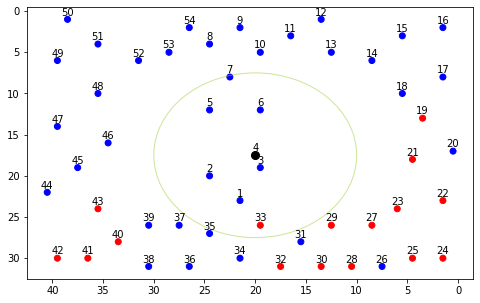

In [ ]:
# plot Cenario
plotCenario(nodes,nodes[3],None)

maxD = 4
*empate de PROF entre [19, 21, 22, 24]
*empate de CHILDs entre [22, 24] com 5 filhos vermelhos
*PANCoord selects 24 as deepest with 164 J
*that have members = [22, 23, 25, 27, 28]
lista atual = [22, 23, 25, 27, 28]
minD = 3
empate de PROF entre [23, 25, 27, 28] [__]
PANCoord selects 27 as deepest [_-]
that have members = [(21, 4, 0), (29, 7, 0), (30, 6, 0)] [_-]
[21, 22, 23, 24, 25, 28, 29, 30]
[]
lista atual = [21, 29, 30]
minD = 2
empate de PROF entre [29, 30] [__]
PANCoord selects 29 as deepest [_-]
that have members = [(32, 4, 0), (33, 3, 0)] [_-]
[23, 25, 27, 28, 30, 32, 33]
[]
lista atual = [32, 33]
minD = 1
PANCoord selects 33 as deepest [_]
that have members = [(4, 0.2)] [_]

procurar azul

 nodos vermelhos nao assoc = [19, 40, 41, 42, 43]
maxD = 4
PANCoord selects 19 as deepest [**]
that have members = [] [**]
lista atual = [21]
minD = 4
PANCoord selects 21 as deepest [_]
that have members = [(19, 0.2)] [_]

procurar azul

maxD = 3
*empate de PROF entre [40, 41, 42, 4

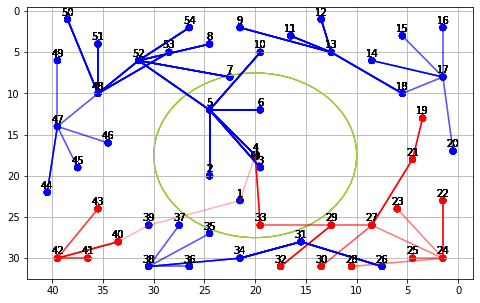

    ID  Depth  Assoc  Childs  ChildCH  nearBlue  nearRed  Energy  idCluster
0    1      1   True       1        0         9        5      89          1
1    4     -1  False       0        0         6        2     128          9
2   19      4   True       0        0         4        1     167          4
3   21      4   True       1        0         2        4      81          4
4   22      4   True       0        0         2        5     116          4
5   23      3   True       0        0         2        7      86          4
6   24      4   True       5        0         1        5     164          4
7   25      3   True       0        0         1        7     195          4
8   27      3   True       3        0         2        8     103          4
9   28      3   True       0        0         2        7      52          4
10  29      2   True       2        0         5        8     160          4
11  30      2   True       0        0         3        6     152          4
12  32      

In [ ]:
def countRedinList(lista):
  l=[]
  # count=0
  for n in lista:
    if n.datarate == 0.2 and n.assoc == False:
      # count += 1
      l.append(n)
  return len(l),l

def countBlueinList(lista):
  l=[]
  for n in lista:
    if n.datarate == 0.05 and n.assoc == False:
      l.append(n)
  return len(l),l

def procuraPANC(nodo,lista):
  for n in lista:
    if n.nodeID==4:
      targ = n.parent
      # print(f'targ = {targ.nodeID}')
      while targ != None:
        if targ == nodo:
          print('encontrado !')
          return True
        else:
          targ = targ.parent
          # if targ !=None:
            # print(f'targ = {targ.nodeID}')
  print('nao encontrado !')
  return False

# Funcao que calcula o potencial de um no candidato a ponte, nesse caso, por quantidade de vermelhos
def calcPotencial(node):
  for n in node.nearBlues:
    if len(n.nearReds) != 0:
      for m in n.nearReds:
        if m.idCluster != node.idCluster:
          n.potencial += 1
        if m.nodeID == 4:
          n.potencial += 50

# Funcao que calcula o potencial de um no candidato a ponte, nesse caso, por quantidade de nos com menor PROF
def calcPotencialPROF(node):
  temp = []
  for n in node.nearBlues:
    minD = min(x.hopToPAN for x in node.nearBlues)
    if n.hopToPAN < node.hopToPAN:
      n.potencial +=1
    if n.hopToPAN == minD:
      n.potencial +=10
    for m in n.neighbors:
      if m.idCluster != node.idCluster:
        n.potencial += 1
      if m.nodeID == 4:
        n.potencial += 50

formDeepestMax(nodes,'r')

myred = []
for n in nodes:
  if n.datarate == 0.2 and n.assoc == False and len(n.child)+len(n.childCH)==0:
    myred.append(n)

print(f' nodos vermelhos nao assoc = {[m.nodeID for m in myred]}')
l=1
if len(myred)!=0:
  while l !=0:
    l,lis = countRedinList(nodes)
    formDeepestMax(lis,'r')

print(f' nodos vermelhos nao assoc = {[m.nodeID for m in lis]}')
allred = []
need = []
PANC = nodes[3]
for n in nodes:
  if n.datarate == 0.2:
    if n.isCH == True:
      allred.append(n)
    if n.idCluster != PANC.idCluster:
      need.append(n)

# for n in nodes:
#   if n.datarate ==0.2:
#     print(f'n = {n.nodeID}')
#     if n.parent != None:
#       print(f'parent = {n.parent.nodeID}')
#     else:
#       print(f'parent = NONE')
a = None
b = None
PANC = nodes[3]
busc = None
for n in allred:
  a = procuraPANC(n,nodes)
  if a == False and n.idCluster != PANC.idCluster:
    print(f'{n.nodeID} nao encontra PANC')
    busc = n
    PANC.assoc = False

# Escolher algoritmo para seguir: 1 - Busca Ramos Vermelhos, 2 - Busca pontes azuis mais rasos
op_alg = int(input('1. Busca ramos vermelhos | 2. Busca o azul até o PANC |\tEscolha: '))
listaCluster = []
if op_alg == 1:
# codigo para potencial RED
  
  for n in nodes:
    if n.idCluster == busc.idCluster:
      calcPotencial(n)
      for m in n.nearBlues:
        if m.potencial != 0:
          n.nearBluesPotencial.append(m)
      listaCluster.append((n.nodeID,len(n.nearBluesPotencial),n.idCluster))
      print(f'{n.nodeID} tem azuis potenciais {[mm.nodeID for mm in n.nearBluesPotencial]}')
elif op_alg == 2:
# codigo para potencialPROF
  # listaCluster = []
  for n in nodes:
    if n.idCluster == busc.idCluster:
      calcPotencialPROF(n)
      for m in n.nearBlues:
        if m.potencial != 0:
          n.nearBluesPotencial.append(m)
      listaCluster.append((n.nodeID,len(n.nearBluesPotencial),n.idCluster))
      print(f'{n.nodeID} tem azuis potenciais {[mm.nodeID for mm in n.nearBluesPotencial]}')
# nodes[6].forceDataRate(0.05)

listaCluster = sorted(listaCluster, key=lambda x: x[1])
print(f'listaCluster = {listaCluster}')
posi = len(listaCluster)-1
change = None
for n in nodes:
  if n.nodeID == listaCluster[posi][0]:
    print(f'Melhor nodo para procurar azul = {n.nodeID}')
    change = n
# formDeepestMax(change.nearReds,'r')
# for n in nodes:
#   if n.nodeID == 1:
#     n.datarate = 0.2

# busc.disassociate()
# for n in nodes:
#   if n.idCluster == busc.idCluster:
#     n.assoc = False
#     n.idCluster = 0
#     busc.idCluster = 0
# formDeepestMax(change.nearReds,'r')
print(f'op_alg = {op_alg}\nchange = {change.nodeID}')
if op_alg == 1:
  testeEscolheAzul(change)
else:
  escolheAzulatePANC(change)

allred.clear()

print('\ninicia formacao de menor prioridade')
allblue = []
for n in nodes:
  if n.datarate == 0.2:
    allred.append(n)
  else:
    allblue.append(n)
nodes[3].assoc = False
nodes[3].forceDataRate(0.05)
nodes[3].isCH = False
for n in nodes:
  if n.nodeID == 4:
    print(f'{n.nodeID} | {n.datarate} | {n.assoc} | {n.parent.nodeID} | {n.idCluster}')
cBlue,lBlue = countBlueinList(nodes)
while cBlue != 0:
  nodes[3].assoc = False
  nodes[3].forceDataRate(0.05)
  formDeepestMax(nodes,'b')
  cBlue, lBlue = countBlueinList(nodes)
  print(f'cBlue = {cBlue}')

all_blue = []
busca_azul = None
for n in nodes:
  if n.datarate == 0.05:
    all_blue.append(n)

ch_blue = []
for n in all_blue:
  if len(n.child)+len(n.childCH)>0:
    ch_blue.append(n)
    # print(f'{n.nodeID} azul CH')

print(f'CHs azuis = {[n.nodeID for n in ch_blue]}')
for n in ch_blue:
    a = procuraPANC(n,ch_blue)
    if a == True and n.idCluster != PANC.idCluster:
      print(f'{n.nodeID} azul nao encontra PANC')
      busca_azul = n

# for n in busca_azul.child:
#   if len(n.child)!=0:
#     for m in n.neighbors:
#       if m.datarate == n.datarate and m.idCluster != n.idCluster:
#         n.associateAllDifCluster(m)

# nodes[2].assoc = False
# nodes[2].forceDataRate(0.05)
# print(f'{len(allred)} nodos nao associados')
# while len(allblue) > 0:
#   nrand = np.random.choice([a for a in allblue if a.hopToPAN == max(n.hopToPAN for n in allblue)])
#   if nrand.assoc == False:
#     print(f'nodo CH escolhido: {nrand.nodeID}\n')  
#     formClusterBottomUp(nrand,nodes,'b')
#   allblue.remove(nrand)
# ax = plt.gca()
# ax.invert_xaxis()
# ax.invert_yaxis()
plt.grid()
plt.show()

tab = pd.DataFrame([x.as_dict() for x in allred])
print(tab)
tab1 = pd.DataFrame([x.as_dict() for x in need])
print(tab1)
tab2 = pd.DataFrame([x.as_dict() for x in all_blue])
print(tab2)


print(f'lista deck = {[n for n in deck]}')

In [ ]:
def procuraPANC(nodo,lista):
  for n in lista:
    if n.nodeID==3:
      targ = n.parent
      while targ != None:
        if targ == nodo and targ.assoc == False:
          print('encontrado !')
          targ.assoc=True
          return True
        else:
          targ = targ.parent
  print('nao encontrado !')
  return False

redNodes = []
blueNodes = []
red = []
for n in nodes:
    if n.nodeID != 3 and n.datarate == 0.2:
        red.append(n)
    if n.nodeID != 3 and n.assoc == False and n.datarate == 0.2:
        redNodes.append(n)
    elif n.nodeID != 3 and n.assoc == False and n.datarate == 0.05:
        blueNodes.append(n)

redNodesWithMaxDepth = []

# Formacao Bottom-up

# Formacao por Escolha de Arvore de Decisao
# Formacao por Score (criar DataFrame no Pandas com D R E para calcular pesos)

max_depth = max(n.hopToPAN for n in redNodes)
for n in redNodes:
  if n.hopToPAN == max_depth:
    redNodesWithMaxDepth.append(n)

for n in nodes:
    if n.nodeID == 4:
        n.datarate=0.2
print(f'{len(redNodes)} nodos nao associados')
while len(redNodes) > 0:
    # nrand = np.random.choice(redNodesWithMaxDepth)
    # nrand = redNodes.moreDepth()
    nrand = np.random.choice([a for a in redNodes if a.hopToPAN == max(n.hopToPAN for n in redNodes)])
    if nrand.assoc == False:
      print(f'nodo CH escolhido: {nrand.nodeID}\n')  
      formClusterBottomUp(nrand,nodes,'r')
    redNodes.remove(nrand)
    # redNodesWithMaxDepth(nrand)
    # print(f'len redNodesW = {len(redNodesWithMaxDepth)}')

#Fase de formacao para Nodos Azuis
# for n in nodes:
#     if n.nodeID == 3:
#         n.datarate=0.05
# while len(blueNodes) > 5:
#     nrand = np.random.choice(blueNodes)
#     print(f'nodo CH escolhido: {nrand.nodeID}')
#     formClusterBottomUp(nrand,nodes,'b')
    # blueNodes.remove(nrand)

# nodes[2].assoc = False
# nodes[2].forceDataRate(0.05)
# print(f'{len(redNodes)} nodos nao associados')
# while len(blueNodes) > 0:
#   nrand = np.random.choice([a for a in blueNodes if a.hopToPAN == max(n.hopToPAN for n in blueNodes)])
#   if nrand.assoc == False:
#     print(f'nodo CH escolhido: {nrand.nodeID}\n')  
#     formClusterBottomUp(nrand,nodes,'b')
#   blueNodes.remove(nrand)

for n in red:
  if n.assoc == False:
    print(n.as_dict())
for n in red:
  if n.assoc == False:
    print(procuraPANC(n,nodes))
choo = None
for n in red:
    if n.assoc == False:
      print(f'Nodo {n.nodeID} possui azuis = {[(m.nodeID,m.hopToPAN) for m in n.neighbors if m.datarate == 0.05]}')
      for m in n.neighbors:                                           # m filhos do vermelho n
        m.hasRedNeig(n)                                               # indica que tem filhos vermelhos de cluster diferente
        if m.datarate == 0.05 and m.hasRedNeighbor == True:           # se tem filhos azuis em 'n' e esse azuis tem vermelhos de outro Cluster
          lowD = min(b.hopToPAN for b in n.neighbors)                 # calcula a menor profundidade daquele grupo
          if m.hopToPAN == lowD:                                      # se um azul tem menor profundidade, verifica os filhos
            for a in m.neighbors:                                       # 'a' filhos dos filhos 'm' dos 'n' vermelhos
              if a.datarate==0.2 and a.idCluster != m.idCluster:                                       # se 'a' eh vermelho      
                  choo = m
                  print(f'azul escolhido = {(choo.nodeID,choo.hopToPAN)}\nalcanca o vermelho = {a.nodeID} com idCluster {a.idCluster}')
                  choo.forceDataRate(0.2)
                  nodes[3].assoc = False
                  a.forceIdCluster(m)
                  choo.selectChildCHBU(a)
                  formClusterBottomUp(choo,nodes,'r')

# ax = plt.gca()
# ax.invert_xaxis()
# ax.invert_yaxis()
plt.grid()
plt.show()

# Criar funcao de selecao de nodo azul para ponte

dreds = pd.DataFrame([x.as_dict() for x in red])

print(dreds)
for n in nodes:
  if n.nodeID == 22:
    print(f'nodo {n.nodeID} alcanca {[m.nodeID for m in n.nearBlues]} Azul')
  if n.nodeID == 21:
    print(f'nodo {n.nodeID} alcanca {[m.nodeID for m in n.nearBlues]} Azul')
  if n.nodeID == 39:
    print(f'nodo {n.nodeID} alcanca {[m.nodeID for m in n.nearReds]} Vermelho')
  if n.nodeID == 37:
    print(f'nodo {n.nodeID} alcanca {[m.nodeID for m in n.nearReds]} Vermelho')
  if n.nodeID == 38:
    print(f'nodo {n.nodeID} alcanca {[m.nodeID for m in n.nearReds]} Vermelho')
  if n.nodeID == 35:
    print(f'nodo {n.nodeID} alcanca {[m.nodeID for m in n.nearReds]} Vermelho')
  if n.nodeID == 36:
    print(f'nodo {n.nodeID} alcanca {[m.nodeID for m in n.nearReds]} Vermelho')

NameError: ignored

In [ ]:
# Pseudo-codigo Algoritmo de Formacao

FormacaoTopologia(){
    FormacaoClustersPrioritarios();
    FormacaoClustersRestantes();
    SolucionaNodosOrfaos();
}

# Formacao Vermelho

FormacaoClustersPrioritarios(NODO){
    enquanto existirem nodos vermelhos nao associados:
      CoordenadorPAN seleciona NODO vermelho mais profundo
      enquanto CoordenadorPAN nao estiver na lista de NODO:
        se existe vermelho na lista de NODO
          para n vermelho na Lista de NODO ate que NODO.childs <= MAX_Childs:
            CoordenadorPAN associa n a NODO.childs
          menorPROF = min(PROF na lista NODO.childs)
          para m na lista NODO.childs:
            se exite m com m.PROF == menorPROF:
              CoordenadorPAN define m como CH
              FormacaoClustersPrioritarios(m)
            se nao:
              menorPROF--
        se nao:
          para n azul na lista de NODO:
            se n possui vermelhos na lista:
              CoordenadorPAN seleciona n com menorPROF
              CoordenadorPAN altera n.datarate para vermelhos
              retorna para linha 13 
      CoordenadorPAN associa-se ao NODO
      return
}

# Formacao Azul

FormacaoClustersRestantes(NODO){
    enquanto existirem nodos azuis nao associados:
      CoordenadorPAN seleciona NODO azul mais profundo
      enquanto CoordenadorPAN nao estiver na lista de NODO:
        se existe azul na lista de NODO
          repete da linha 16 a 24 para nodos Azuis
        se nao:
          desassocia nodo tornando-o orfao          
      CoordenadorPAN associa-se ao NODO
      return
}

# Ajuste Topologia para Nodos Orfaos

SolucionaNodosOrfaos(NODO){
    enquanto existirem nodos azuis nao associados:
      CoordenadorPAN associa NODO à CH vermelhos com menorPROF
}